In [1]:
import sys  
sys.path.insert(0, r'C:\Users\marci\Desktop\Python\Numba-tutorial')
import numpy as np
import matplotlib.pyplot as plt
from numba import int64, int32, float64, float32, cuda, guvectorize

In [2]:
from codes.FractionalAbundance import FractionalAbundance

In [3]:
FA = FractionalAbundance(element="Ar", concurrent=True)

In [4]:
K = FA.K

In [5]:
product_all = [K[0]]
current_product = K[0]
sum_all = np.zeros_like(K[0])
for i in range(1,len(K)):
    current_product = np.multiply(K[i], current_product)
    sum_all += current_product
    product_all.append(current_product)

In [6]:
FA_np = [np.divide(product_all[ion], sum_all) for ion in range(FA.Z + 1)]

In [7]:
FA_output = np.zeros_like(K)

In [8]:
for i in range(K.shape[1]):
    for j in range(K.shape[2]):
        sum_all = 0.0
        current_product = 1.0
        product_all = []
        for k in range(K.shape[0]):
            current_product *= K[k,i,j]
            sum_all += current_product
            product_all.append(current_product)
        for k in range(K.shape[0]):    
              FA_output[k,i,j] = product_all[k]/sum_all

In [9]:
np.array_equal(FA_output, FA.FA_arr)

False

In [10]:
np.allclose(FA_output[0], FA.FA_arr[0])

True

In [11]:
FA_output.shape

(19, 800, 100)

In [12]:
FA.FA_arr[0].shape

(800, 100)

In [13]:
np.allclose(FA_output[0], FA_np[0])

True

### Numba

In [14]:
import math
from numba import cuda
import math 
from numba import float32, float64
from pdb import set_trace

In [15]:
array_K = K.copy()

In [58]:
threadsperblock = (FA.Z+1, 5, 5)
blockspergrid_x = math.ceil(array_K.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(array_K.shape[1] / threadsperblock[1])
blockspergrid_z = math.ceil(array_K.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
print(threadsperblock)
print(blockspergrid)
print(array_K.shape)
print(threadsperblock[0]*threadsperblock[1]*threadsperblock[2] < 1024)
print(array_K.shape[0] == threadsperblock[0]*blockspergrid[0])
print(array_K.shape[1] == threadsperblock[1]*blockspergrid[1])
print(array_K.shape[2] == threadsperblock[2]*blockspergrid[2])

(19, 5, 5)
(1, 160, 20)
(19, 800, 100)
True
True
True
True


In [49]:
@cuda.jit('void(float64[:,:,:], float64[:,:,:])')
def calculate_FA_gpu(X,Y):
    #cuda.syncthreads()
    k, j, i = cuda.grid(3)
    if i < X.shape[2] and j < X.shape[1] and k < X.shape[0]:
        sum_all = 0
        current_product = 1
        #cuda.syncthreads()
        for k in range(X.shape[0]):
            current_product *= X[k, j, i]
            sum_all += current_product
            Y[k, j, i] = current_product
            cuda.syncthreads()
        cuda.syncthreads()
        for k in range(X.shape[0]):
            Y[k, j, i] = Y[k, j, i] / sum_all
            cuda.syncthreads()
        #cuda.syncthreads()

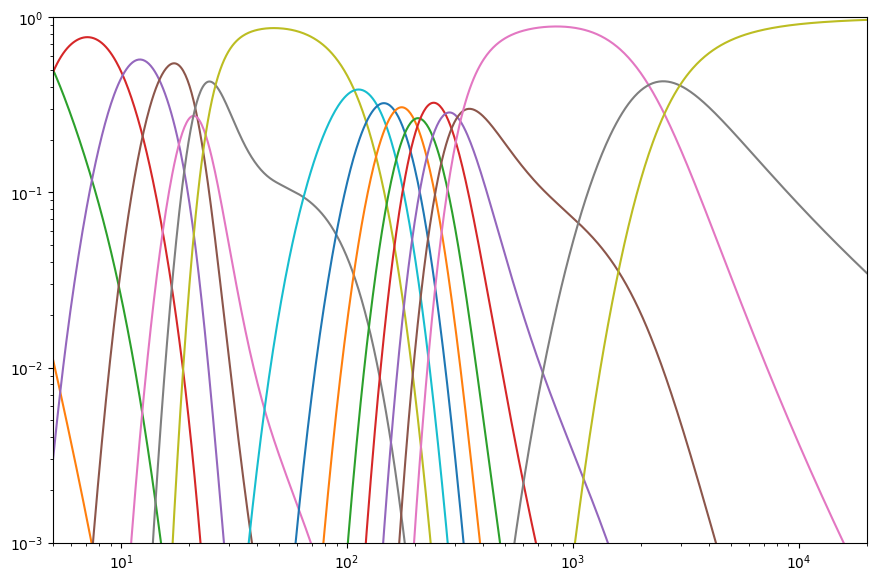

In [55]:
# X array
device_array = cuda.to_device((array_K).astype(np.float64))
# Y array
result_array = cuda.device_array_like(np.ones_like(array_K).astype(np.float64))
calculate_FA_gpu[blockspergrid, threadsperblock](device_array,
                                                     result_array)
cuda.synchronize()
result_gpu = result_array.copy_to_host()


for ion in range(0, FA.Z+1):
    #result_gpu[ion,:,50][~np.isfinite(result_gpu[ion,:,50])] = 1
    plt.plot(FA.Te_new,result_gpu[ion,: ,50])
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim((10**-3, 10**0))
    plt.xlim((5, 20000))

In [19]:
result_gpu.shape

(19, 800, 100)

In [20]:
#%timeit calculate_FA_gpu[blockspergrid, threadsperblock](device_array, result_array)

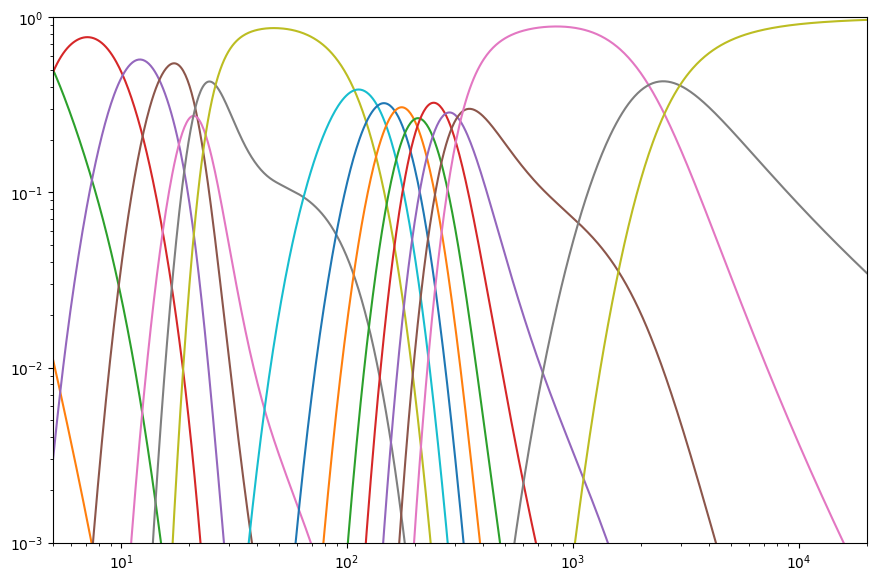

In [21]:
for ion in range(FA.Z+1):
    plt.plot(FA.Te_new,FA_output[ion,:,50])
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim((10**-3, 10**0))
    plt.xlim((5, 20000))

In [22]:
result_gpu[10,:,50]

array([2.40252765e-109, 8.83282671e-107, 2.14540845e-104, 3.47457980e-102,
       3.79150606e-100, 2.82025495e-098, 1.44851366e-096, 5.21041146e-095,
       1.33318091e-093, 2.46802704e-092, 3.36731930e-091, 3.45467243e-090,
       2.72363883e-089, 1.68925433e-088, 8.45302589e-088, 3.50664712e-087,
       1.24161178e-086, 3.87118605e-086, 1.09889819e-085, 2.94306129e-085,
       7.72448153e-085, 2.06889981e-084, 5.90338544e-084, 1.87445495e-083,
       6.73621925e-083, 2.73079528e-082, 1.24366935e-081, 6.33434231e-081,
       3.59033794e-080, 2.25253976e-079, 1.55517686e-078, 1.17412798e-077,
       9.62762406e-077, 8.51141879e-076, 8.04888884e-075, 8.07314858e-074,
       8.51105649e-073, 9.33995364e-072, 1.05591356e-070, 1.21629190e-069,
       1.41079838e-068, 1.62733292e-067, 1.84204092e-066, 2.01746618e-065,
       2.10620353e-064, 2.06356687e-063, 1.88167462e-062, 1.59789046e-061,
       1.26525801e-060, 9.35562869e-060, 6.47059136e-059, 4.19367541e-058,
       2.55223142e-057, 1

In [23]:
FA_output[10,:,50]

array([2.40252765e-109, 8.83282671e-107, 2.14540845e-104, 3.47457980e-102,
       3.79150606e-100, 2.82025495e-098, 1.44851366e-096, 5.21041146e-095,
       1.33318091e-093, 2.46802704e-092, 3.36731930e-091, 3.45467243e-090,
       2.72363883e-089, 1.68925433e-088, 8.45302589e-088, 3.50664712e-087,
       1.24161178e-086, 3.87118605e-086, 1.09889819e-085, 2.94306129e-085,
       7.72448153e-085, 2.06889981e-084, 5.90338544e-084, 1.87445495e-083,
       6.73621925e-083, 2.73079528e-082, 1.24366935e-081, 6.33434231e-081,
       3.59033794e-080, 2.25253976e-079, 1.55517686e-078, 1.17412798e-077,
       9.62762406e-077, 8.51141879e-076, 8.04888884e-075, 8.07314858e-074,
       8.51105649e-073, 9.33995364e-072, 1.05591356e-070, 1.21629190e-069,
       1.41079838e-068, 1.62733292e-067, 1.84204092e-066, 2.01746618e-065,
       2.10620353e-064, 2.06356687e-063, 1.88167462e-062, 1.59789046e-061,
       1.26525801e-060, 9.35562869e-060, 6.47059136e-059, 4.19367541e-058,
       2.55223142e-057, 1

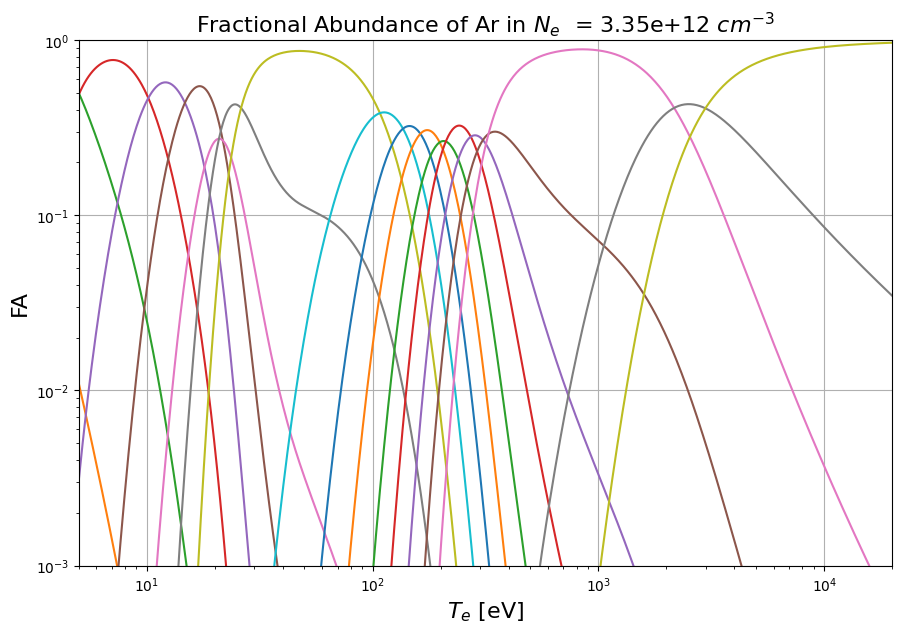

In [24]:
FA.plot_FA_all()

### Tests

In [25]:
np.random.seed(1)
array_random = np.random.rand(3,2,1)
array_random

array([[[4.17022005e-01],
        [7.20324493e-01]],

       [[1.14374817e-04],
        [3.02332573e-01]],

       [[1.46755891e-01],
        [9.23385948e-02]]])

In [26]:
array = np.insert(array_random,[0],[1,1]).reshape(4,2,1)
array

array([[[1.00000000e+00],
        [1.00000000e+00]],

       [[4.17022005e-01],
        [7.20324493e-01]],

       [[1.14374817e-04],
        [3.02332573e-01]],

       [[1.46755891e-01],
        [9.23385948e-02]]])

In [27]:
array[1][1][0]

0.7203244934421581

In [28]:
def multidim_cumsum(array,sums=False):
    array_out = []
    for i in range(array.shape[1]):
        for j in range(array.shape[2]):
            if sums:
                array_out.append(np.cumprod(array[:,i,j])/np.cumprod(array[:,i,j]).sum())
            else:
                array_out.append(np.cumprod(array[:,i,j]))
    return np.array(array_out).T.reshape(4,2,1)

In [29]:
multidim_cumsum(array)

array([[[1.00000000e+00],
        [1.00000000e+00]],

       [[4.17022005e-01],
        [7.20324493e-01]],

       [[4.76968156e-05],
        [2.17777557e-01]],

       [[6.99978866e-06],
        [2.01092736e-02]]])

In [30]:
array.shape

(4, 2, 1)

In [31]:
array[0, 1, 0]

1.0

In [32]:
threadsperblock = (2, 2, 1)
blockspergrid_x = math.ceil(array.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(array.shape[1] / threadsperblock[1])
blockspergrid_z = math.ceil(array.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
print('blocks',blockspergrid)
print('threads',threadsperblock)
print(array.shape)

blocks (2, 1, 1)
threads (2, 2, 1)
(4, 2, 1)


In [33]:
from numba import cuda
import math 
from numba import float32 
@cuda.jit()
def cum_prod(X,Y):
    cuda.syncthreads()
    k, j, i = cuda.grid(3)
    if i < X.shape[2] and j < X.shape[1] and k < X.shape[0]:
        current_product = 1
        sum_all = 0
        for k in range(X.shape[0]):
            current_product *= X[k,j,i]
            Y[k, j, i] = current_product
            sum_all += current_product
        cuda.syncthreads()
        for k in range(X.shape[0]):
            Y[k, j, i] = Y[k, j, i] / sum_all

In [34]:
# X array
device_array = cuda.to_device((array).astype(np.float32))
# Y array
result_array = cuda.device_array_like(device_array)

cum_prod[blockspergrid, threadsperblock](device_array,
                                                     result_array)
cuda.synchronize()
result_gpu = result_array.copy_to_host()
result_gpu

C:\Users\marci\AppData\Roaming\Python\Python39\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([[[7.0567811e-01],
        [5.1067013e-01]],

       [[2.9428330e-01],
        [3.6784819e-01]],

       [[3.3658598e-05],
        [1.1121249e-01]],

       [[4.9395971e-06],
        [1.0269205e-02]]], dtype=float32)

In [35]:
np.array_equal(result_gpu, multidim_cumsum(array,sums=True))

False

In [36]:
np.allclose(result_gpu, multidim_cumsum(array,sums=True))

True

In [37]:
multidim_cumsum(array,sums=True)

array([[[7.05678104e-01],
        [5.10670114e-01]],

       [[2.94283298e-01],
        [3.67848191e-01]],

       [[3.36585984e-05],
        [1.11212490e-01]],

       [[4.93959759e-06],
        [1.02692050e-02]]])

In [38]:
cuda.detect()

Found 1 CUDA devices
id 0          b'NVIDIA T500'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-18c0c16d-d4f9-016a-277e-948d06a0c634
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [39]:
1024/118

8.677966101694915